## MDS Thesis
#### 05. Regressions with GELECTRA prediction results

<br>
<hr style="opacity: 0.5">

### Setup

In [ ]:
# had to install statsmodels this way
#!/Users/varvarailyina/hertie/mds_thesis/env/bin/python -m pip install statsmodels

In [57]:
# load libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler

In [58]:
# set wd
ROOT_DIR = "/Users/varvarailyina/hertie/mds_thesis/data"

-- *Load data*

In [59]:
# load data
df_gelectra = pd.read_pickle(os.path.join(ROOT_DIR, "out", "df_res_gelectra.pkl"))

In [60]:
df_gelectra.columns

Index(['party', 'date', 'month', 'issue_mono', 'issue_label', 'text', 'anger',
       'fear', 'disgust', 'sadness', 'joy', 'enthusiasm', 'pride', 'hope',
       'n_sentences', 'total_emotion_mentions', 'emotion_intensity',
       'anger_share', 'fear_share', 'disgust_share', 'sadness_share',
       'joy_share', 'enthusiasm_share', 'pride_share', 'hope_share'],
      dtype='object')

-- *Specify things*

In [61]:
# specify emotion columns
emotion_cols = ['anger', 'fear', 'disgust', 'sadness', 'joy', 'enthusiasm', 'pride', 'hope']

In [62]:
# specify issue labels
issue_map = {
    1: "Macroeconomics",
    2: "Civil Rights",
    3: "Health",
    4: "Agriculture",
    5: "Labor",
    6: "Education",
    7: "Environment",
    8: "Energy",
    9: "Immigration",
    10: "Transportation",
    12: "Law and Crime",
    13: "Social Welfare",
    14: "Housing",
    15: "Domestic Commerce",
    16: "Defense",
    17: "Technology",
    18: "Foreign Trade",
    20: "Government Operations",
    23: "Culture",
    191: "International Affairs",
    192: "European Integration"
}

-- *Clean `df_reg` for regressions*

In [63]:
# only keep press releases with > 3 sentences
df_reg = df_gelectra[df_gelectra['n_sentences'] >= 4].copy()

# convert 'month' to string
df_reg['month'] = df_reg['month'].astype(str)

# convert 'month' to datetime
df_reg['month_dt'] = pd.to_datetime('20' + df_reg['month'], format='%Y%m')

# replace 'month' column with YYYY-MM
df_reg['month'] = df_reg['month_dt'].dt.strftime('%Y-%m')

# convert 'date' column to 'YYYY-MM-DD'
df_reg['date'] = pd.to_datetime(df_reg['date']).dt.date
df_reg['date'] = df_reg['date'].astype(str)

<hr style="opacity: 0.5">

### Top issue by party by month

-- *Dummy variables for each issue*

In [64]:
# binary dummy variables for each issue
issue_dummies = pd.get_dummies(df_reg['issue_mono'], prefix='issue')
df_reg = pd.concat([df_reg, issue_dummies], axis=1)

-- *Top issue per party per month*

In [65]:
# count number of press releases per party, month, and issue
issue_counts = (
    df_reg
    .groupby(['party', 'month', 'issue_mono'])
    .size()
    .reset_index(name='count')
)

# identify the top issue for each party and month
top_issues = (
    issue_counts
    .sort_values(['party', 'month', 'count'], ascending=[True, True, False])
    .groupby(['party', 'month'])
    .first()
    .reset_index()
    .rename(columns={'issue_mono': 'top_issue'})
)

# merge top issue info back onto `df_reg`
df_reg = df_reg.merge(
    top_issues[['party', 'month', 'top_issue']],
    on=['party', 'month'],
    how='left'
)

In [66]:
# binary var for whether issue is top issue for that party and month
df_reg['top_issue_monthly'] = df_reg['issue_mono'] == df_reg['top_issue']

In [67]:
# output how often each issue was top issue for each party
n_top_issue_counts = (
    df_reg[df_reg['top_issue_monthly']]
    .drop_duplicates(subset=['party', 'month', 'issue_label'])
    .groupby(['party', 'issue_label'])
    .size()
    .reset_index(name='n_top_issue_months')
    .sort_values(['party', 'n_top_issue_months'], ascending=[True, False])
)

-- *Share of months with top issue per party*

In [68]:
# number of months per party
total_months_per_party = (
    df_reg[['party', 'month']].drop_duplicates()
    .groupby('party')
    .size()
    .reset_index(name='n_months')
)

# merge total months into `top_issue_counts`
top_issue_counts = n_top_issue_counts.merge(total_months_per_party, on='party', how='left')

# calculate share of months where each issue was top
top_issue_counts['share_top_issue'] = (
    top_issue_counts['n_top_issue_months'] / top_issue_counts['n_months']
).round(3)

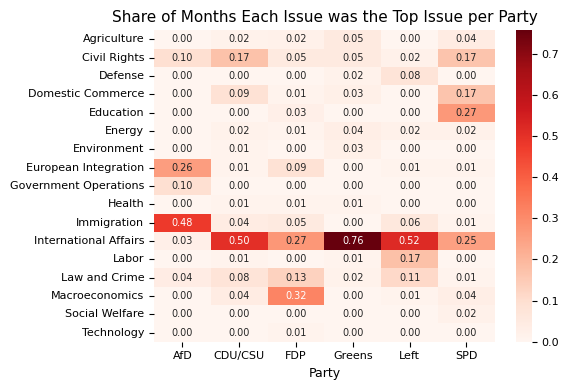

In [69]:
# heatmap
heatmap_data = top_issue_counts.pivot(
    index='issue_label', columns='party', values='share_top_issue'
).fillna(0)

plt.figure(figsize=(6, 4))

ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap='Reds',
    annot_kws={"size": 7}
)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)

plt.xlabel('Party', fontsize=9)
plt.ylabel('', fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Share of Months Each Issue was the Top Issue per Party', fontsize=11)
plt.tight_layout()
plt.show()

# 0.48 means in 48% of the months, this issue was the top issue for that party
# 0.00 means the issue was never the top issue for that party
# higher value = more dominant issue across the time period (2010-2019)

# sums up to 100% vertically across issues

<hr style="opacity: 0.5">

### Run Regressions

-- *Specifications*

In [101]:
# make `CDU/CSU` party reference category
#df_reg['party'] = pd.Categorical(
#    df_reg['party'],
#    categories=[
#        'CDU/CSU', 'SPD', 'Greens', 'FDP', 'Left', 'AfD'
#    ],
#    ordered=True)

# make `AfD` party reference category
df_reg['party'] = pd.Categorical(
    df_reg['party'],
    categories=['AfD', 'CDU/CSU', 'SPD', 'Greens', 'FDP', 'Left'],
    ordered=False
)

# make `Civil Rights` issue reference category
df_reg['issue_label'] = pd.Categorical(
    df_reg['issue_label'],
    categories=[
        "Civil Rights", "Agriculture", "Culture", "Defense", "Domestic Commerce",
        "Education", "Energy", "Environment", "European Integration", "Foreign Trade",
        "Government Operations", "Health", "Housing", "Immigration", "International Affairs", "Labor",
        "Law and Crime", "Macroeconomics", "Social Welfare", "Technology", "Transportation"
    ],
    ordered=True
)

In [102]:
# fixed effects specifications
fe_specs = [
    ('No FE', ''),
    ('Party FE', '+ C(party)'),
    ('Month FE', '+ C(month)'),
    ('Two-Way FE', '+ C(party) + C(month)')
]

-- *Emotional effect of individual issues*

In [103]:
# store results
reg_results = []

# regression loop
for emotion in emotion_cols:
    for spec_name, fe_formula in fe_specs:
        formula = f"{emotion} ~ C(issue_label){fe_formula}"
        model = smf.ols(formula, data=df_reg).fit()

        for var in model.params.index:
            if var.startswith("C(issue_label)[T."):
                reg_results.append({
                    'emotion': emotion,
                    'issue': var.replace('C(issue_label)[T.', '').replace(']', ''),
                    'coef': model.params[var],
                    'ci_low': model.conf_int().loc[var, 0],
                    'ci_high': model.conf_int().loc[var, 1],
                    'fe_spec': spec_name
                })

# combine results
df_reg_plot = pd.DataFrame(reg_results)

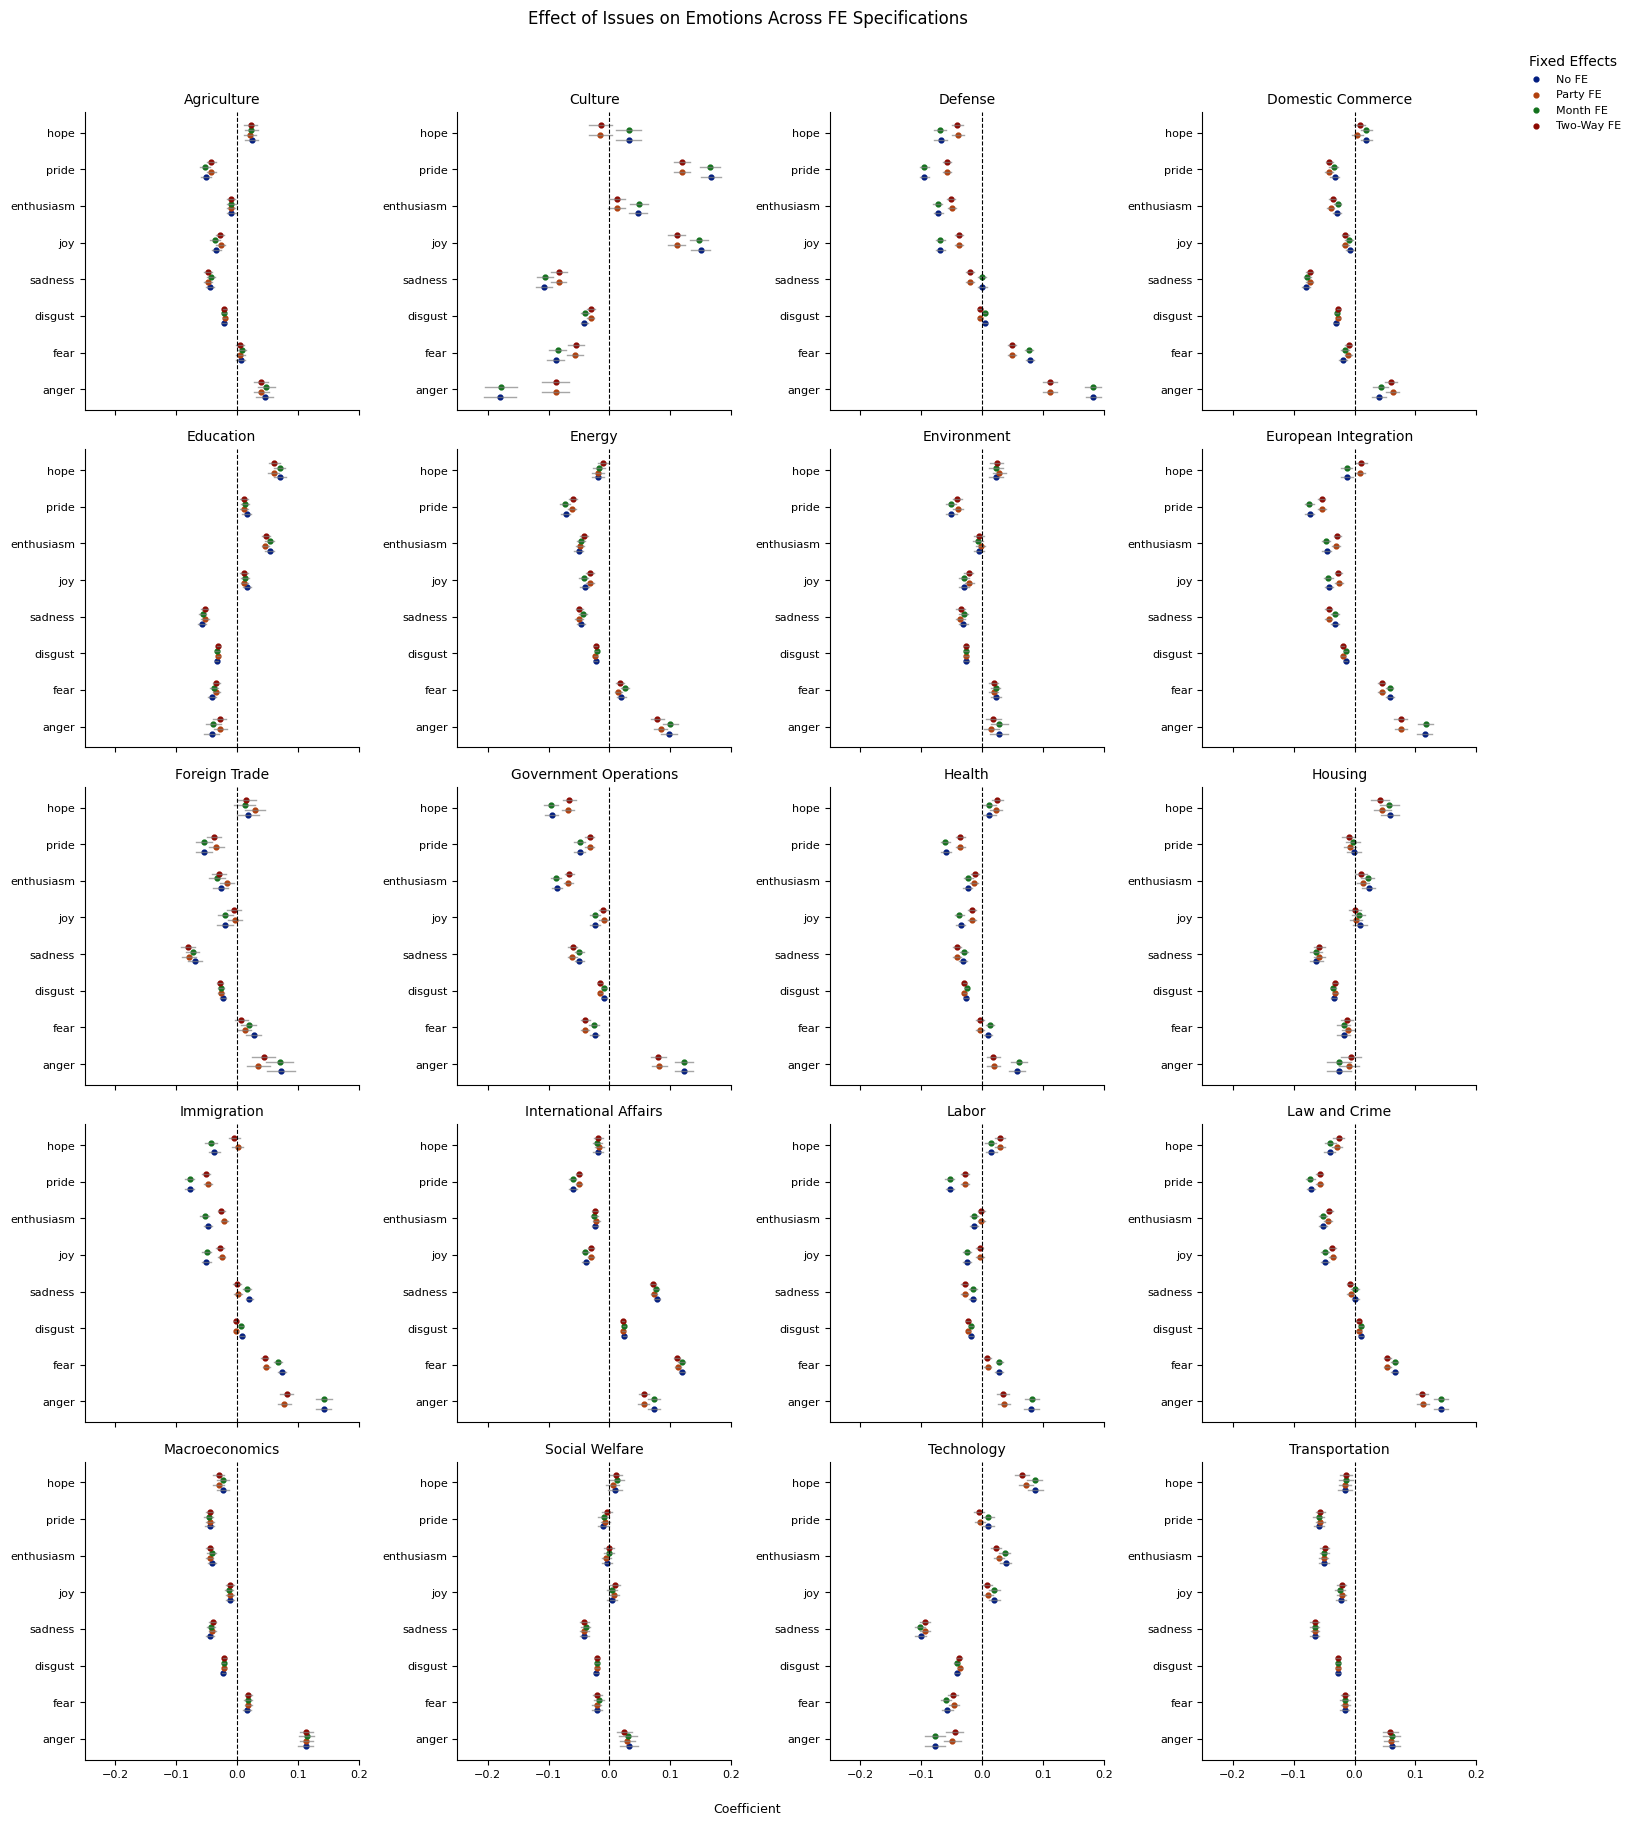

In [106]:
# plot loop (facet wrap)

# set up the dodge and palette
fe_specs_unique = df_reg_plot['fe_spec'].unique()
palette = sns.color_palette('dark', n_colors=len(fe_specs_unique))
dodge_value = 0.4
offsets = np.linspace(-dodge_value / 2, dodge_value / 2, len(fe_specs_unique))

# create FacetGrid (1 per issue)
g = sns.FacetGrid(
    df_reg_plot,
    col='issue',
    col_wrap=4,
    height=3.5,
    sharex=True,
    sharey=False
)

# define plotting function for each facet
def facet_scatter(data, color, **kwargs):
    emotions = data['emotion'].unique()
    for idx, fe_spec in enumerate(fe_specs_unique):
        subset = data[data['fe_spec'] == fe_spec]
        y_positions = np.array([list(emotions).index(e) for e in subset['emotion']])
        plt.scatter(subset['coef'], y_positions + offsets[idx], label=fe_spec, color=palette[idx], s=12)

        # error bars
        for _, row in subset.iterrows():
            emotion_idx = list(emotions).index(row['emotion'])
            plt.plot([row['ci_low'], row['ci_high']],
                     [emotion_idx + offsets[idx], emotion_idx + offsets[idx]],
                     color='gray', alpha=0.7, linewidth=1)

    plt.axvline(0, linestyle='--', linewidth=0.8, color='black')
    plt.yticks(range(len(emotions)), emotions, fontsize=8)
    plt.xticks(fontsize=8)

# map the plotting function to grid
g.map_dataframe(facet_scatter)

# adjust titles and labels
g.set_axis_labels("", "")
g.set_titles("{col_name}")

# add legend outside the grid
g.add_legend(title="Fixed Effects", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=8)

# adjust x-limits globally
for ax in g.axes.flat:
    ax.set_xlim(-0.25, 0.2)

plt.suptitle("Effect of Issues on Emotions Across FE Specifications", y=1.02)
plt.figtext(0.5, -0.01, 'Coefficient', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

# anger ~ C(agriculture){two-way FE}", relative to issue reference category
# effect of each issue (IV) on each emotion (DV)
# reference category: civil rights bc not owned by any party, kind of salient, not emotionally extreme

# how much more / less likely is an emotion expressed per issue

-- *Which emotions associated with which issues?*

In [77]:
# dummy variables for each issue
issue_labels = sorted(df_reg['issue_label'].dropna().unique())

In [96]:
# run reg per issue
reg_results = []

for issue in issue_labels:
    df_reg['issue_dummy'] = (df_reg['issue_label'] == issue).astype(int)

    for spec_label, fe_formula in [
        ('No FE', ''),
        ('Party FE', '+ C(party)'),
        ('Month FE', '+ C(month)'),
        ('Two-Way FE', '+ C(party) + C(month)')
    ]:
        emotion_terms = ' + '.join(emotion_cols)
        formula = f"issue_dummy ~ {emotion_terms} {fe_formula}"
        model = smf.ols(formula, data=df_reg).fit()

        for var in model.params.index:
            if var in emotion_cols:
                reg_results.append({
                    'issue': issue,
                    'emotion': var,
                    'coef': model.params[var],
                    'ci_low': model.conf_int().loc[var, 0],
                    'ci_high': model.conf_int().loc[var, 1],
                    'fe_spec': spec_label
                })

# make df
df_reg_plot = pd.DataFrame(reg_results)

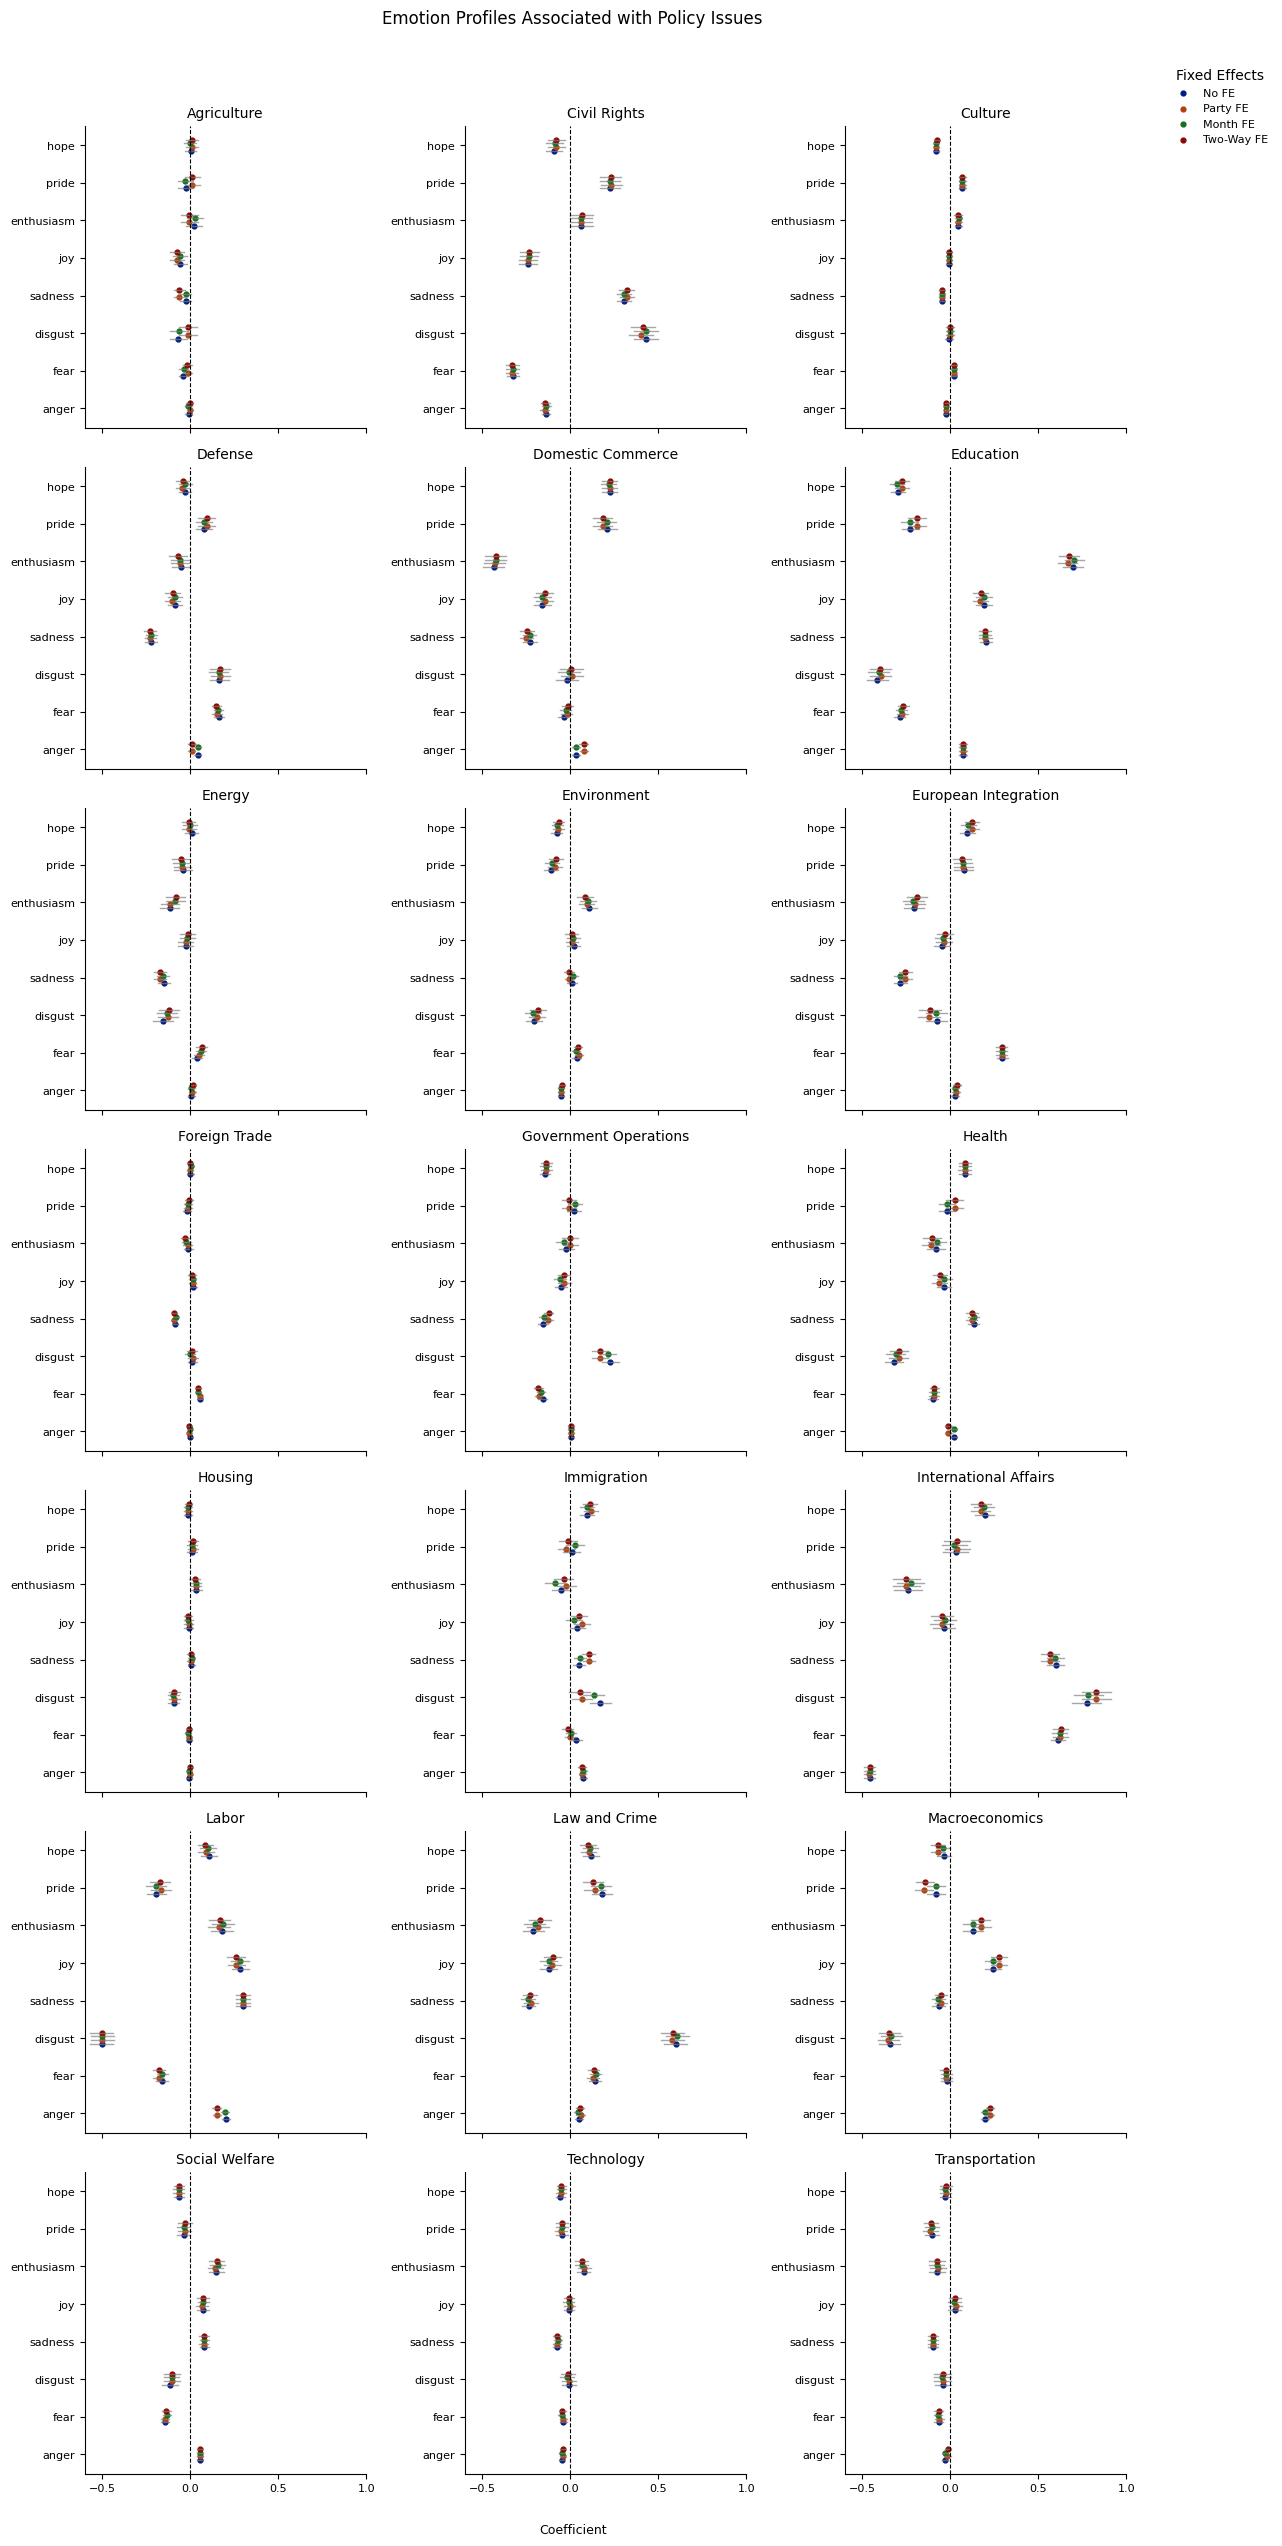

In [98]:
# plot per issue

# emotion order
emotion_order = ['anger', 'fear', 'disgust', 'sadness', 'joy', 'enthusiasm', 'pride', 'hope']

# palette and offsets
fe_specs = df_reg_plot['fe_spec'].unique()
palette = sns.color_palette('dark', n_colors=len(fe_specs))
offsets = np.linspace(-0.3 / 2, 0.3 / 2, len(fe_specs))

# FacetGrid
g = sns.FacetGrid(
    df_reg_plot,
    col='issue',
    col_wrap=3,
    height=3.5,
    sharex=True,
    sharey=False
)

def plot_facet(data, **kwargs):
    emotions = emotion_order
    for idx, fe_spec in enumerate(fe_specs):
        subset = data[data['fe_spec'] == fe_spec]
        y_pos = [emotions.index(e) for e in subset['emotion']]
        plt.scatter(subset['coef'], np.array(y_pos) + offsets[idx], color=palette[idx], s=12, label=fe_spec)

        for _, row in subset.iterrows():
            e_idx = emotions.index(row['emotion'])
            plt.plot([row['ci_low'], row['ci_high']],
                     [e_idx + offsets[idx]] * 2,
                     color='gray', alpha=0.7, linewidth=1)

    plt.axvline(0, linestyle='--', color='black', linewidth=0.8)
    plt.yticks(range(len(emotions)), emotions, fontsize=8)
    plt.xticks(fontsize=8)

g.map_dataframe(plot_facet)
g.set_titles("{col_name}")
g.set_axis_labels("", "")
g.add_legend(title="Fixed Effects", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=8)

g.set(xlim=(-0.6, 1))

plt.suptitle("Emotion Profiles Associated with Policy Issues", y=1.02)
plt.figtext(0.5, -0.01, 'Coefficient', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

# which emotions are associated with which issues?
# issue_dummy ~ anger + fear + ... + fixed effects

# high positive values for an emotion = more likely the issue is addressed
# high negative values for an emotion = less likely the issue is addressed

# the more fear in a press release, the more likely it is to be about international affairs

-- *Issue saliency*

In [82]:
# redefine fixed effects specifications
fe_specs = [
    ('No FE', ''),
    ('Party FE', '+ C(party)'),
    ('Month FE', '+ C(month)'),
    ('Two-Way FE', '+ C(party) + C(month)')
]

In [83]:
# store results
reg_results = []

# loop through each emotion and fixed effects
for emotion in emotion_cols:
    
    for spec_name, fe_formula in fe_specs:
        formula = f"{emotion} ~ top_issue_monthly{fe_formula}"
        model = smf.ols(formula, data=df_reg).fit()
        
        if 'top_issue_monthly[T.True]' in model.params.index:
            reg_results.append({
                'emotion': emotion,
                'coef': model.params['top_issue_monthly[T.True]'],
                'ci_low': model.conf_int().loc['top_issue_monthly[T.True]', 0],
                'ci_high': model.conf_int().loc['top_issue_monthly[T.True]', 1],
                'fe_spec': spec_name
            })

# combine results into df
df_reg_plot = pd.DataFrame(reg_results)

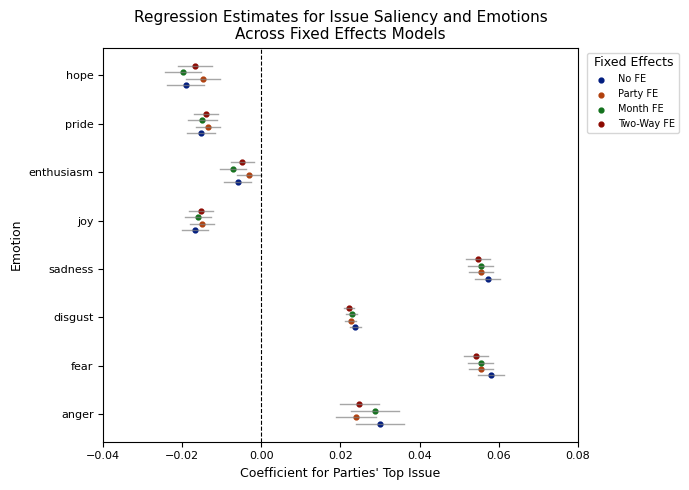

In [88]:
# plot issue saliency across emotions
plt.figure(figsize=(7, 5))

# define palette and dodge
palette = sns.color_palette('dark', n_colors=len(fe_specs))
dodge_value = 0.4
emotions = df_reg_plot['emotion'].unique()
offsets = np.linspace(-dodge_value / 2, dodge_value / 2, len(fe_specs))

# plot loop
for idx, fe_spec in enumerate(fe_specs):
    spec_name = fe_spec[0]
    subset = df_reg_plot[df_reg_plot['fe_spec'] == spec_name]
    y_positions = np.array([list(emotions).index(e) for e in subset['emotion']])

    plt.scatter(subset['coef'], y_positions + offsets[idx], label=spec_name, color=palette[idx], s=12)

    # error bars
    for _, row in subset.iterrows():
        emotion_idx = list(emotions).index(row['emotion'])
        plt.plot([row['ci_low'], row['ci_high']],
                 [emotion_idx + offsets[idx], emotion_idx + offsets[idx]],
                 color='gray', alpha=0.7, linewidth=1)

# reference line at zero
plt.axvline(0, linestyle='--', linewidth=0.8, color='black')

# labels and title
plt.xlim(-0.04, 0.08)
plt.xticks(fontsize=8)
plt.yticks(range(len(emotions)), emotions, fontsize=8)
plt.xlabel("Coefficient for Parties' Top Issue", fontsize=9)
plt.ylabel('Emotion', fontsize=9)
plt.title("Regression Estimates for Issue Saliency and Emotions\nAcross Fixed Effects Models", fontsize=11)

# legend
plt.legend(
    title='Fixed Effects',
    title_fontsize=9,
    fontsize=7,
    bbox_to_anchor=(1.01, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()

# top issue per party because of issue saliency theory
# coef plot linking party issue saliency to emotion shares in press releases

# positive coef = higher issue saliency associated with emotion XX


-- *Specify parties' owned issues*

In [89]:
# parties' owned issues
owned_issues = {
    'AfD': ['Immigration'],
    'Greens': ['Environment'], # Agriculture
    'SPD': ['Social Welfare'],
    'FDP': ['Macroeconomics'],
    'Left': ['Labor'],
    'CDU/CSU': ['Law and Crime']
}

In [90]:
# create 'owned_issue' binary per party
df_reg['owned_issue'] = df_reg.apply(
    lambda row: 1 if row['issue_label'] in owned_issues.get(row['party'], []) else 0,
    axis=1
)

-- *Issue ownership heterogeneity (subset by party)*

In [91]:
# results across all parties
res_all = []

for party, owned_issue_list in owned_issues.items():
    subset = df_reg[df_reg['party'] == party].copy()
    subset['owned_issue'] = subset['issue_label'].isin(owned_issue_list).astype(int)

    for emotion in emotion_cols:

        for fe_label, fe_formula in [('No FE', ''), ('Month FE', '+ C(month)')]:
            formula = f"{emotion} ~ owned_issue {fe_formula}"
            model = smf.ols(formula, data=subset).fit()

            if 'owned_issue' in model.params.index:
                res_all.append({
                    'party': party,
                    'owned_issue_label': ', '.join(owned_issue_list),
                    'emotion': emotion,
                    'coef': model.params['owned_issue'],
                    'ci_low': model.conf_int().loc['owned_issue', 0],
                    'ci_high': model.conf_int().loc['owned_issue', 1],
                    'p_value': model.pvalues['owned_issue'],
                    'n_obs': int(model.nobs),
                    'r_squared': model.rsquared,
                    'fe_spec': fe_label
                })

# results to df
df_res_all = pd.DataFrame(res_all)

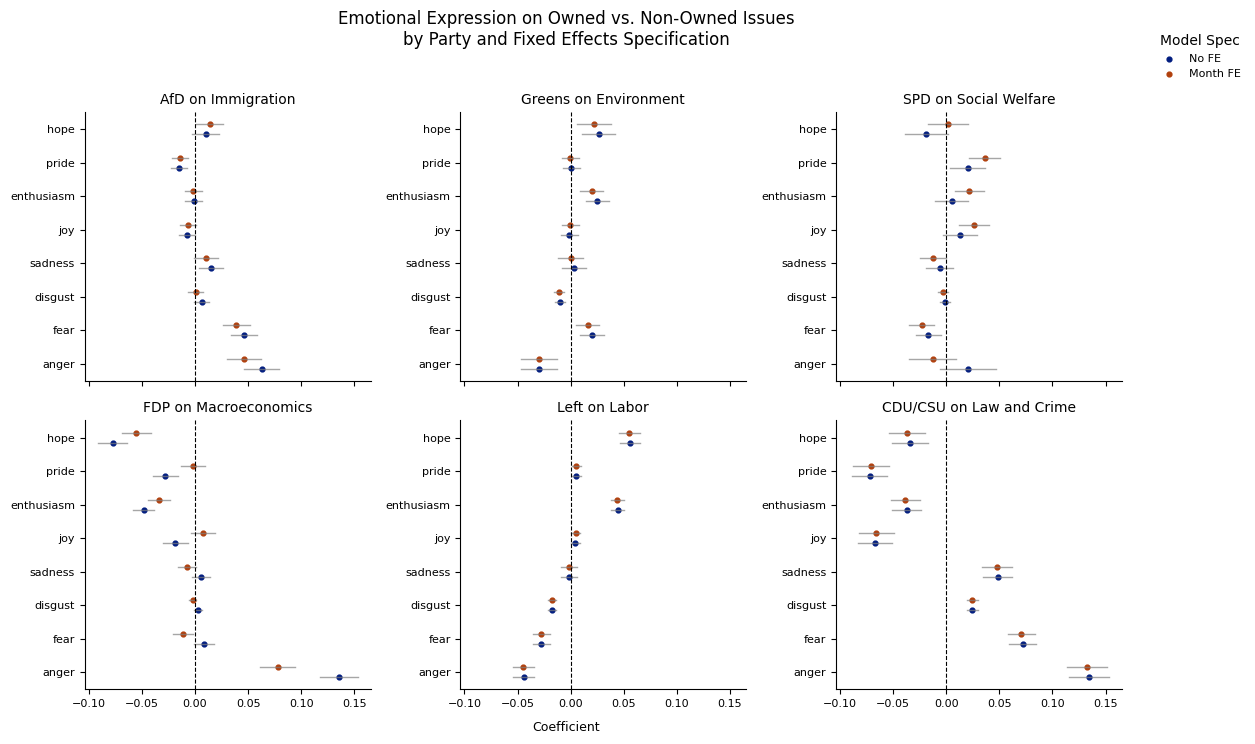

In [92]:
# plot for every party's owned issue

# define palette and offsets
fe_specs = df_res_all['fe_spec'].unique()
palette = sns.color_palette('dark', n_colors=len(fe_specs))
dodge_value = 0.3
offsets = np.linspace(-dodge_value / 2, dodge_value / 2, len(fe_specs))

# add plot title column
df_res_all['plot_title'] = df_res_all['party'] + " on " + df_res_all['owned_issue_label']

# FacetGrid by party
g = sns.FacetGrid(
    df_res_all,
    col='plot_title',
    col_wrap=3,
    height=3.5,
    sharex=True,
    sharey=False
)

# define scatter function for each facet
def facet_scatter(data, color, **kwargs):
    #emotions = sorted(data['emotion'].unique())
    emotion_order = ['anger', 'fear', 'disgust', 'sadness', 'joy', 'enthusiasm', 'pride', 'hope']
    emotions = emotion_order
    
    for idx, fe_spec in enumerate(fe_specs):
        subset = data[data['fe_spec'] == fe_spec]
        y_positions = np.array([list(emotions).index(e) for e in subset['emotion']])

        plt.scatter(subset['coef'], y_positions + offsets[idx], label=fe_spec, color=palette[idx], s=12)

        for _, row in subset.iterrows():
            emotion_idx = list(emotions).index(row['emotion'])
            plt.plot([row['ci_low'], row['ci_high']],
                     [emotion_idx + offsets[idx], emotion_idx + offsets[idx]],
                     color='gray', alpha=0.7, linewidth=1)

    plt.axvline(0, linestyle='--', linewidth=0.8, color='black')
    plt.yticks(range(len(emotions)), emotions, fontsize=8)
    plt.xticks(fontsize=8)

# map the function to the grid
g.map_dataframe(facet_scatter)

# adjust labels
g.set_axis_labels("", "")
g.set_titles("{col_name}")
g.add_legend(title="Model Spec", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=8)

# title and layout
plt.suptitle("Emotional Expression on Owned vs. Non-Owned Issues\nby Party and Fixed Effects Specification", y=1.02)
plt.figtext(0.5, -0.01, 'Coefficient', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

# subset for party, compare issue_owned treatment vs. non owned issues

-- *Issue ownership heterogeneity (subset by issue)*

In [93]:
# issues' owning parties
issue_owners = {
    'Immigration': ['AfD'],
    'Environment': ['Greens'],
    'Social Welfare': ['SPD'],
    'Macroeconomics': ['FDP'],
    'Labor': ['Left'],
    'Law and Crime': ['CDU/CSU']
}

In [94]:
# results across all issues
res_all = []

for issue, owning_parties in issue_owners.items():
    subset = df_reg[df_reg['issue_label'] == issue].copy()
    subset['owning_party'] = subset['party'].isin(owning_parties).astype(int)
    
    for emotion in emotion_cols:
        
        for fe_label, fe_formula in [('No FE', ''), ('Month FE', '+ C(month)')]:
            formula = f"{emotion} ~ owning_party {fe_formula}"
            model = smf.ols(formula, data=subset).fit()
            
            if 'owning_party' in model.params.index:
                res_all.append({
                    'issue_label': issue,
                    'owning_parties_label': ', '.join(owning_parties),
                    'emotion': emotion,
                    'coef': model.params['owning_party'],
                    'ci_low': model.conf_int().loc['owning_party', 0],
                    'ci_high': model.conf_int().loc['owning_party', 1],
                    'p_value': model.pvalues['owning_party'],
                    'n_obs': int(model.nobs),
                    'r_squared': model.rsquared,
                    'fe_spec': fe_label
                })

# results to df
df_res_all = pd.DataFrame(res_all)
df_res_all['plot_title'] = df_res_all['issue_label'] + " (Owned by: " + df_res_all['owning_parties_label'] + ")"

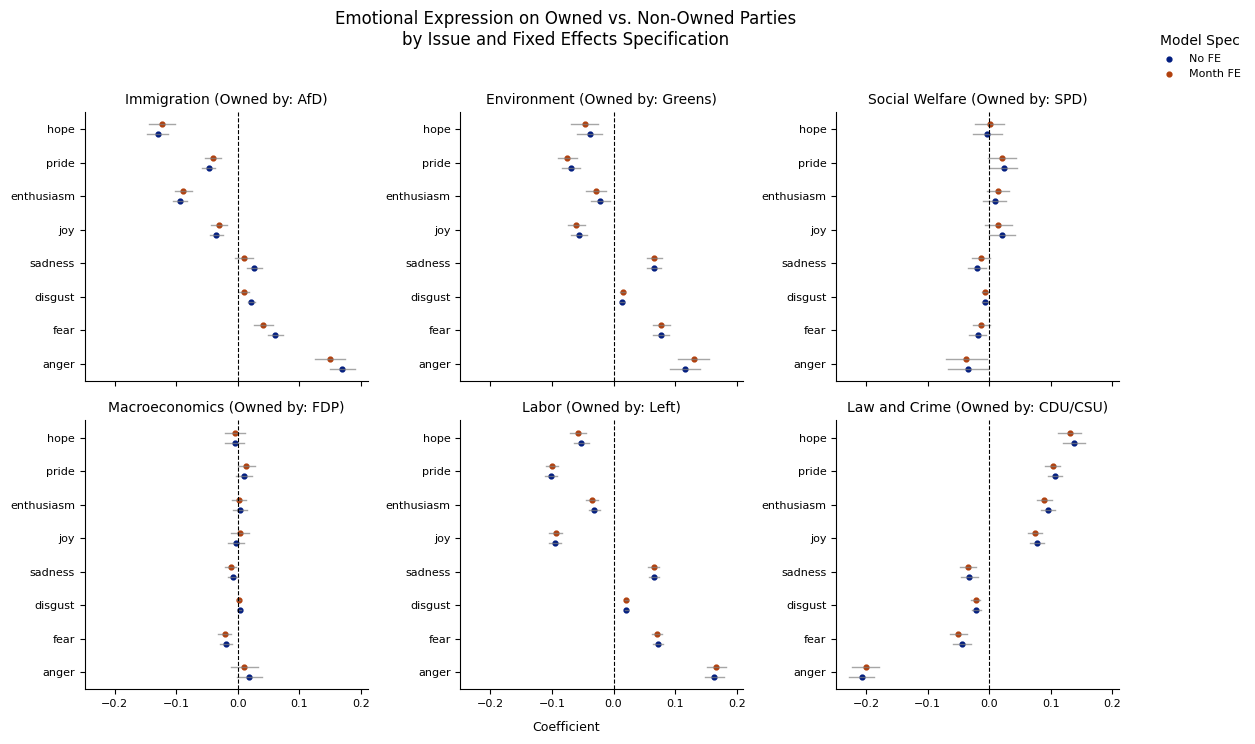

In [95]:
# define palette and offsets
fe_specs = df_res_all['fe_spec'].unique()
palette = sns.color_palette('dark', n_colors=len(fe_specs))
dodge_value = 0.3
offsets = np.linspace(-dodge_value / 2, dodge_value / 2, len(fe_specs))

# FacetGrid by issue
g = sns.FacetGrid(
    df_res_all,
    col='plot_title',
    col_wrap=3,
    height=3.5,
    sharex=True,
    sharey=False
)

# scatter plotting function
def facet_scatter_issue(data, color, **kwargs):
    emotion_order = ['anger', 'fear', 'disgust', 'sadness', 'joy', 'enthusiasm', 'pride', 'hope']
    emotions = emotion_order
    
    for idx, fe_spec in enumerate(fe_specs):
        subset = data[data['fe_spec'] == fe_spec]
        y_positions = np.array([list(emotions).index(e) for e in subset['emotion']])
        
        plt.scatter(subset['coef'], y_positions + offsets[idx], label=fe_spec, color=palette[idx], s=12)
        
        for _, row in subset.iterrows():
            emotion_idx = list(emotions).index(row['emotion'])
            plt.plot([row['ci_low'], row['ci_high']],
                     [emotion_idx + offsets[idx], emotion_idx + offsets[idx]],
                     color='gray', alpha=0.7, linewidth=1)
    
    plt.axvline(0, linestyle='--', linewidth=0.8, color='black')
    plt.yticks(range(len(emotions)), emotions, fontsize=8)
    plt.xticks(fontsize=8)

# apply plotting function
g.map_dataframe(facet_scatter_issue)

# labels and titles
g.set_axis_labels("", "")
g.set_titles("{col_name}")
g.add_legend(title="Model Spec", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=8)
plt.suptitle("Emotional Expression on Owned vs. Non-Owned Parties\nby Issue and Fixed Effects Specification", y=1.02)
plt.figtext(0.5, -0.01, 'Coefficient', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

# subset for issue, compare issue_owning_party as treatment vs. non owning party